# Considerações:
- Exemplo usando LangChain e a funcionalidade Caching

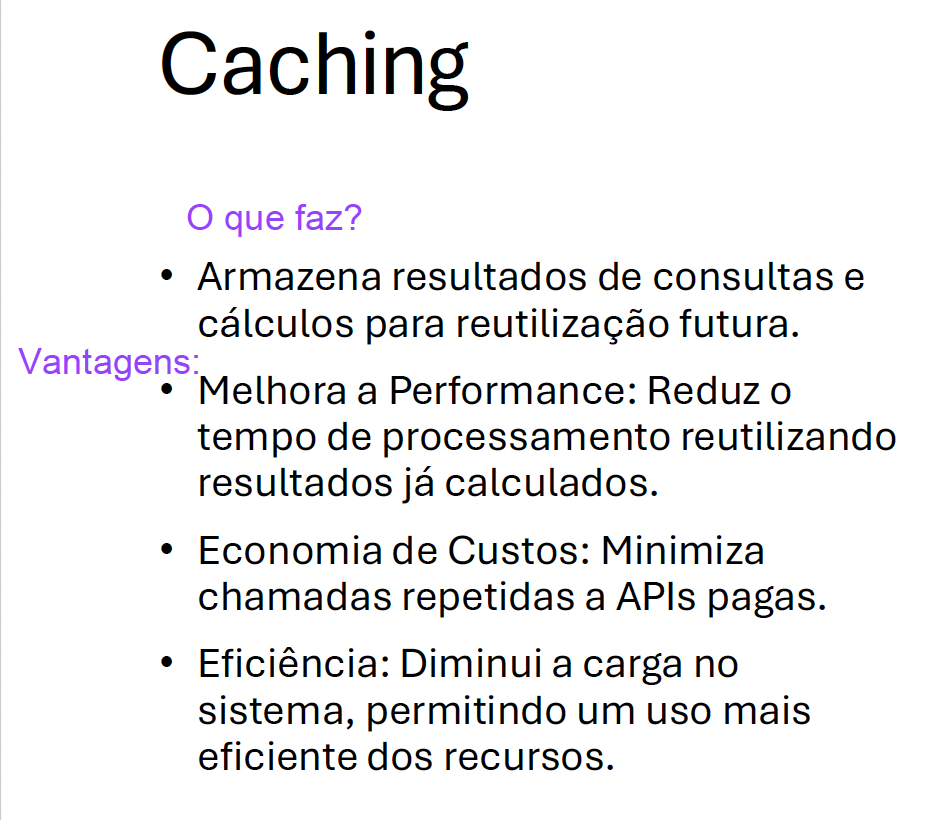

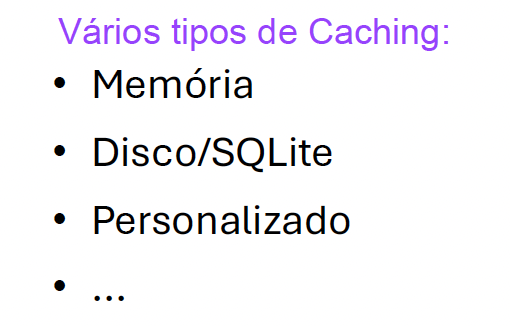

# Setup

In [1]:
# importando as bibliotecas

from langchain_openai import OpenAI
from langchain.cache import InMemoryCache,SQLiteCache # imports do Caching
from langchain.globals import set_llm_cache # define o cache que está sendo utilizado
import os
import json
import hashlib
import yaml

In [2]:
# lendo o arquivo config.yaml para ter acesso a chave de acesso da OpenAI

with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)
os.environ['OPENAI_API_KEY'] = config['OPENAI_API_KEY']

# Memória


- O **InMemoryCache** é um mecanismo de cache que armazena temporariamente dados na memória (RAM) de um sistema ou aplicação. - Amplamente usado em aplicações de inteligência artificial generativa, como as que envolvem LangChain, para melhorar o desempenho e evitar o processamento redundante de informações.

- **O que é o InMemoryCache?**

InMemoryCache armazena dados diretamente na memória volátil (RAM) do servidor ou do computador.
Ele é rápido porque não envolve operações de leitura/escrita em disco ou chamadas a bancos de dados externos.
Como os dados são mantidos apenas em memória, eles não persistem após a reinicialização da aplicação.

- **Uso do InMemoryCache no LangChain**

No contexto do LangChain, o InMemoryCache pode ser usado para armazenar temporariamente resultados de execuções anteriores do modelo de linguagem. Isso é útil em cenários como:

    - Evitar consultas repetitivas: Quando uma mesma solicitação é feita várias vezes, o LangChain pode retornar o resultado do cache, em vez de consultar novamente o LLM.
    
    - Melhorar a performance: Reduz o tempo de resposta e o uso de recursos (custo de chamadas ao modelo).
    
    - Manter dados durante interações temporárias: Ajuda a manter o estado e o histórico da interação sem a necessidade de um banco de dados externo.
    
    - Por exemplo: Se uma aplicação faz uma consulta frequente como "Qual é a capital da França?", a resposta "Paris" pode ser armazenada no cache. Se a mesma pergunta for feita novamente, a aplicação recupera a resposta do cache, economizando tempo e custos.

- **Características principais do InMemoryCache:**

    - Baixa latência: A recuperação dos dados é quase instantânea.
    - Temporário: Os dados não persistem entre reinicializações da aplicação.
    - Gerenciamento simples: Geralmente, é fácil de implementar e configurar.
    - Espaço limitado: O cache na memória está limitado ao tamanho da RAM disponível no sistema.

- **Vantagens**

    - Velocidade: Recuperação de dados extremamente rápida.
    - Redução de custos: Menos chamadas a APIs pagas (como GPT).
    - Eficiência: Evita processamento redundante e libera recursos do modelo.

- **Limitações**

    - Volatilidade: Os dados são perdidos se a aplicação for reiniciada.
    - Capacidade limitada: A quantidade de dados armazenados depende da memória disponível.
    - Escalabilidade: Em sistemas distribuídos ou com múltiplos servidores, manter um cache em memória sincronizado pode ser desafiador.

- O InMemoryCache armazena tanto o prompt quanto a resposta em memória. Ele utiliza o prompt (ou a combinação de entradas) como uma chave e a resposta gerada pelo modelo como o valor associado. Isso significa que, para cada chamada ao modelo, ele verifica se aquele mesmo prompt já foi processado antes e, em caso positivo, retorna a resposta armazenada no cache em vez de fazer uma nova chamada ao modelo.

- **Como funciona o armazenamento:**

    - Chave (Key):

        - O cache utiliza o prompt completo (incluindo variáveis) como a chave. Isso garante que diferentes entradas gerem diferentes registros no cache.

    - Valor (Value):

        - O cache armazena a resposta gerada pelo modelo com base no prompt fornecido.

In [3]:
openai = OpenAI(model_name='gpt-3.5-turbo-instruct') # metodo OpenAI disponível pela biblioteca langchain_openai

set_llm_cache(InMemoryCache()) # definindo o tipo de cache a ser usado

# O cache em Memória, deste exemplo, ele não persiste, então pode ocorrer da aplicação reiniciar e, após um usuário fazer a mesma requisição
# e nesse caso, será feita a chamada para api do modelo novamente.

In [4]:
prompt = 'Me diga em poucas palavras que foi Carl Sagan.' # input
response1 = openai.invoke(prompt) # através do objeto instanciado openai e chamando o método 'invoke' passando como a 'prompt' indicada 
print("Primeira resposta (API chamada):", response1) # imprimindo a resposta do modelo

Primeira resposta (API chamada): 

Carl Sagan foi um renomado astrônomo, astrofísico, escritor e divulgador científico norte-americano, conhecido por sua contribuição para a pesquisa e divulgação da ciência, especialmente na área da cosmologia e exploração espacial. Ele também foi um defensor da educação científica e do pensamento crítico. Sua série de televisão "Cosmos" e seus livros populares, como "O Mundo Assombrado pelos Demônios", tornaram a ciência acessível ao grande público e inspiraram gerações de cientistas.


In [5]:
response2 = openai.invoke(prompt)
print("Segunda resposta (usando cache):", response2)

Segunda resposta (usando cache): 

Carl Sagan foi um renomado astrônomo, astrofísico, escritor e divulgador científico norte-americano, conhecido por sua contribuição para a pesquisa e divulgação da ciência, especialmente na área da cosmologia e exploração espacial. Ele também foi um defensor da educação científica e do pensamento crítico. Sua série de televisão "Cosmos" e seus livros populares, como "O Mundo Assombrado pelos Demônios", tornaram a ciência acessível ao grande público e inspiraram gerações de cientistas.


- Acima é chamado o modelo da openai duas vezes.
- **o resultado das duas chamadas ao modelo é o mesmo**, pois ele guarda a resposta e o prompt em memória.
- Como foi perguntado na sequência, ele ainda tem a resposta em memória e dessa forma são iguais.
- Ao reiniciar, por exemplo, o sistema e rodar novamente o mesmo prompt, provável que terá uma resposta diferente, pois o que estava salvo em memória foi apagado.

# Disco / Banco de Dados

- O **caching em disco ou em banco de dados** é uma estratégia para armazenar dados em um sistema de armazenamento persistente, como o disco local, um banco de dados relacional (SQL), ou um banco de dados NoSQL.
- É usado como alternativa ou complemento ao cache em memória, especialmente em cenários onde a persistência e escalabilidade são importantes.


- **Como funciona?**
  
    - Chave-Valor: O cache geralmente funciona com um modelo de chave-valor, onde a chave é uma identificação única (como um prompt ou entrada) e o valor é a resposta ou dado associado.

    - Armazenamento Persistente: Os dados são armazenados no disco ou no banco de dados e podem ser recuperados mesmo após a reinicialização da aplicação ou interrupções do sistema.

    - Consulta: Quando a aplicação precisa de um dado:

        - Primeiro, verifica o cache (em disco ou banco de dados).
        - Se o dado existir (cache hit), ele é retornado diretamente.
        - Caso contrário (cache miss), o dado é processado (ou buscado externamente) e armazenado no cache para uso futuro.

- **Vantagens**

    - Persistência:
        - Diferente do cache em memória, os dados permanecem disponíveis mesmo após reinicializações ou falhas do sistema.

    - Maior capacidade:
        - O armazenamento em disco ou banco de dados permite lidar com volumes de dados maiores do que o armazenamento em memória, que é limitado pelo tamanho da RAM.

    - Escalabilidade:
        - É mais fácil escalar caches em disco ou bancos de dados para grandes volumes de dados, especialmente em sistemas distribuídos.

    - Integração com sistemas existentes:
        - Bancos de dados tradicionais podem ser reutilizados como cache, facilitando a integração com sistemas já em produção.
          

- **Desvantagens**
  
    - Velocidade:
        - Operações de leitura/escrita em disco ou banco de dados são significativamente mais lentas do que em memória (RAM), o que pode impactar o desempenho.

    - Manutenção:
        - Requer configuração e manutenção adicional, especialmente em sistemas distribuídos, onde a consistência e a sincronização podem ser desafiadoras.

    - Latência em sistemas distribuídos:
        - Em sistemas distribuídos, o acesso a bancos de dados ou caches baseados em disco pode introduzir latência adicional devido à comunicação entre nós.

    - Sobrecarga de I/O:
        - O uso intensivo do disco ou do banco de dados para cache pode causar sobrecarga de I/O (entrada/saída), afetando o desempenho de outras partes do sistema.


- **Características do Cache em Disco ou Banco de Dados**

    - Persistência:
        - Os dados sobrevivem a reinicializações ou falhas, tornando-o útil para aplicações onde a integridade dos dados é crítica.

    - Flexibilidade de armazenamento:
        - Pode ser implementado com:
            - Arquivos simples no disco (ex.: arquivos JSON ou SQLite).
            - Bancos de dados relacionais (ex.: MySQL, PostgreSQL).
            - Bancos de dados NoSQL (ex.: Redis com persistência, MongoDB).
    - Estratégias de expiração:
        - Permite configurar TTL (time-to-live) para remover dados obsoletos automaticamente.

    - Suporte a grandes volumes de dados:
        - Pode armazenar dados muito maiores do que o cache em memória, dependendo do espaço disponível no disco ou na base de dados.

    - Menor custo de hardware:
        - O armazenamento em disco geralmente é mais barato do que aumentar a quantidade de RAM para cache em memória.

- **Implementações Comuns**
  
    - Redis (com persistência):
        - Apesar de ser usado principalmente como cache em memória, Redis pode ser configurado para persistir dados no disco, garantindo uma combinação de velocidade e persistência.

    - SQLite:
        - Um banco de dados leve baseado em arquivo. Ideal para caching local em aplicações de pequeno porte.

    - PostgreSQL/MySQL:
        - Bancos de dados relacionais podem ser usados para implementar caching em sistemas mais complexos.

    - MongoDB:
        - Um banco de dados NoSQL que permite armazenar documentos grandes com chaves personalizadas, sendo útil para caching de dados complexos.


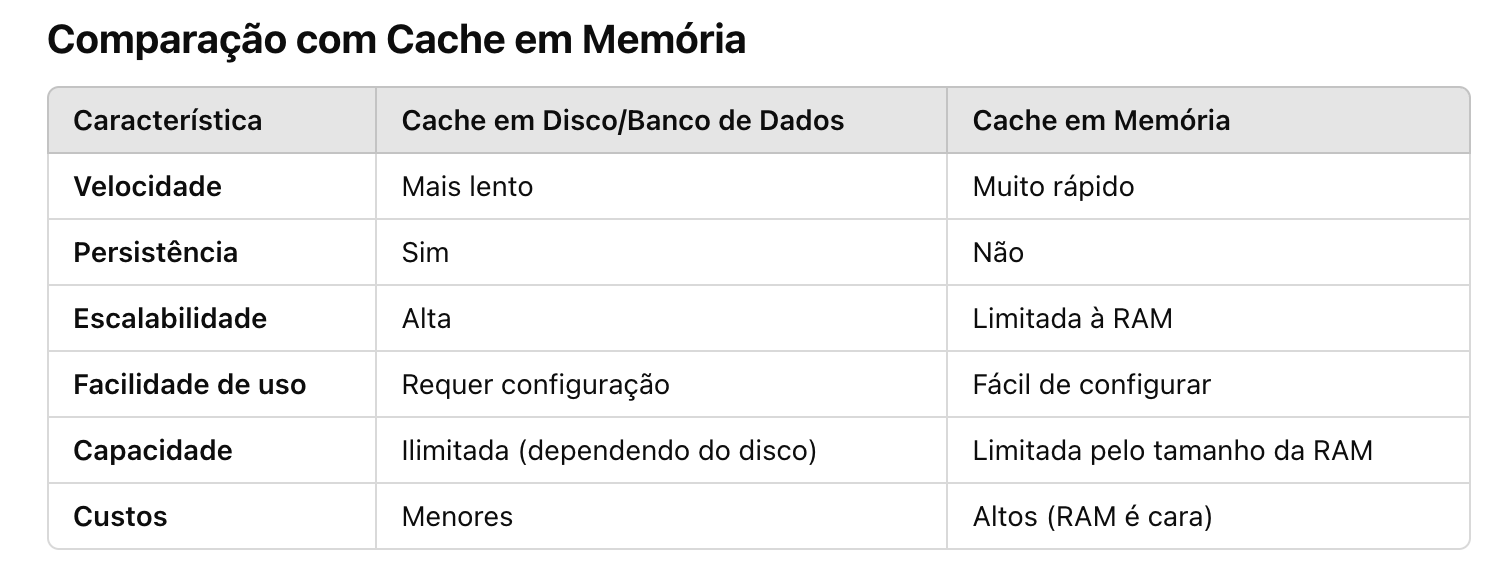

In [7]:
set_llm_cache(SQLiteCache(database_path="openai_cache.db")) # a biblioteca langchain já tem o metodo SQLiteCache que é útil para pequenos volume de dados

# 'database_path="openai_cache.db"' --> indica o nome do banco de dados, ao ser executado a célula o arquivo será criado

In [8]:
prompt = 'Me diga em poucas palavras quem foi Neil Armstrong.' # prompt/input para o modelo

- fazendo o mesmo teste de chamar o prompt duas vezes para observar as respostas, nesse caso, enquanto o prompt for o mesmo, a resposta também será a mesma, pois está salva no banco de dados esse conjunto chave-valor, ou seja, prompt e resposta.

In [9]:
response1 = openai.invoke(prompt)
print("Primeira resposta (API chamada):", response1)

Primeira resposta (API chamada): 

Neil Armstrong foi um astronauta americano e o primeiro ser humano a pisar na Lua durante a missão Apollo 11 em 1969. Ele é considerado um dos maiores exploradores espaciais da história.


In [10]:
response2 = openai.invoke(prompt)
print("Segunda resposta (usando cache):", response2)

Segunda resposta (usando cache): 

Neil Armstrong foi um astronauta americano e o primeiro ser humano a pisar na Lua durante a missão Apollo 11 em 1969. Ele é considerado um dos maiores exploradores espaciais da história.


# Personalizado

- Exemplo abaixo usando o Caching de forma personalizada, no caso, será criado uma forma de cache personalizado em arquivo json

In [11]:
# Construção da classe e dos metodos que cria, procura e salva o cache

class SimpleDiskCache:
    def __init__(self, cache_dir='cache_dir'):
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def _get_cache_path(self, key):
        hashed_key = hashlib.md5(key.encode()).hexdigest() #hasg cria nome de arquivo único
        return os.path.join(self.cache_dir, f"{hashed_key}.json")

    def lookup(self, key, llm_string): # procura se já tem um cache salvo
        cache_path = self._get_cache_path(key)
        if os.path.exists(cache_path):
            with open(cache_path, 'r') as f:
                return json.load(f)
        return None

    def update(self, key, value, llm_string): # update ou salvamento de novo cache
        cache_path = self._get_cache_path(key)
        with open(cache_path, 'w') as f:
            json.dump(value, f)

# ao chamar a classe é salvo um arquivo json com o hash criado para o prompt e no corpo do arquivo fica salvo a resposta.

In [12]:
cache = SimpleDiskCache() # criando uma instância da classe SimpleDiskCache()
set_llm_cache(cache) # indica que a instância criada será a forma utilizada de caching
prompt = 'Me diga em poucas palavras quem foi Neil Degrasse Tyson.' # ao passar pelos métodos da classe SimpleDiskCache
# o prompt é transformado em um hash para ser salvo juntamente da resposta, no caso, pasta cache_dir.
# assim, depois com o metodo lookup, se tiver o mesmo prompt novamente, será transformado em hash e procurado no banco
# se já teve esse prompt rodado e retorna a resposta já salva.

In [13]:
def invoke_with_cache(llm, prompt, cache):
    cached_response = cache.lookup(prompt, "")
    if cached_response:
        print("Usando cache:")
        return cached_response

    response = llm.invoke(prompt)
    cache.update(prompt, response, "")
    return response

In [14]:
response1 = invoke_with_cache(openai, prompt, cache)
response_text1 = response1.replace('\n', ' ') 

print("Primeira resposta (API chamada):", response_text1)

Primeira resposta (API chamada):   Neil Degrasse Tyson é um famoso astrofísico e divulgador científico americano, conhecido por suas contribuições no estudo do universo e por popularizar a ciência através de livros, documentários e programas de TV. 


In [15]:
response2 = invoke_with_cache(openai, prompt, cache)
response_text2 = response2.replace('\n', ' ')  

print("Segunda resposta (usando cache):", response_text2)

Usando cache:
Segunda resposta (usando cache):   Neil Degrasse Tyson é um famoso astrofísico e divulgador científico americano, conhecido por suas contribuições no estudo do universo e por popularizar a ciência através de livros, documentários e programas de TV. 
